In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, DataStructs
from rdkit.Chem.Descriptors import MolWt
import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import StratifiedKFold

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns
sns.set(style='ticks', context='notebook', font_scale=1.2)

# Chemprop inputs
-----

In [2]:
# load table with info on polymers
df_names_dict = pd.read_csv('names_dict.csv')
df_names_dict = df_names_dict.set_index('Name')

# load table with preprocessed polymer input strings
df_names2chemprop = pd.read_csv('block_info.csv')
df_names2chemprop = df_names2chemprop.set_index('Name')

In [3]:
df = pd.read_csv('diblock.csv')

# cleanup strings
df.loc[:, 'phase1'] = df.loc[:, 'phase1'].str.strip()
df.loc[:, 'phase2'] = df.loc[:, 'phase2'].str.strip()
df.loc[:, 'name1'] = df.loc[:, 'name1'].str.strip()
df.loc[:, 'name2'] = df.loc[:, 'name2'].str.strip()

cols = ['name1', 'name2', 'BigSMILES', 'phase1', 'phase2', 'T', 'f1', 'f2', 'rho1', 'rho2', 'Mn', 'DOI']
df = df.loc[:, cols]
df

/home/maldeghi/miniconda3/envs/poly_py37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (11,15,28,97,99) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,name1,name2,BigSMILES,phase1,phase2,T,f1,f2,rho1,rho2,Mn,DOI
0,PS,PDMS,{[][$]CC(c1ccccc1)[$][$]}{[>][<][Si](C)(C)O[>][]},sphere,NaN,25.0,0.08,0.92,NaN,NaN,60803.57143,https://doi.org/10.1016/0032-3861(95)99001-B
1,PS,PDMS,{[][$]CC(c1ccccc1)[$][$]}{[>][<][Si](C)(C)O[>][]},cylinder,NaN,25.0,0.16,0.84,NaN,NaN,66576.57658,https://doi.org/10.1016/0032-3861(95)99001-B
2,PS,PDMS,{[][$]CC(c1ccccc1)[$][$]}{[>][<][Si](C)(C)O[>][]},lamellar,NaN,25.0,0.35,0.65,NaN,NaN,43669.72477,https://doi.org/10.1016/0032-3861(95)99001-B
3,PS,PDMS,{[][$]CC(c1ccccc1)[$][$]}{[>][<][Si](C)(C)O[>][]},cylinder,NaN,25.0,0.56,0.44,NaN,NaN,42735.84906,https://doi.org/10.1016/0032-3861(95)99001-B
4,PS,PDMS,{[][$]CC(c1ccccc1)[$][$]}{[>][<][Si](C)(C)O[>][]},cylinder,NaN,25.0,0.66,0.34,NaN,NaN,39056.60377,https://doi.org/10.1016/0032-3861(95)99001-B
...,...,...,...,...,...,...,...,...,...,...,...,...
5371,PEO,PEE,"{[][<]CCO[>][<]}{[$][$]CCCC[$],[$]CC(CC)[$][]}",gyroid,NaN,223.0,0.70,0.30,NaN,NaN,8400.00000,10.1126/science.271.5251.976
5372,PEO,PEE,"{[][<]CCO[>][<]}{[$][$]CCCC[$],[$]CC(CC)[$][]}",gyroid,NaN,224.0,0.70,0.30,NaN,NaN,8400.00000,10.1126/science.271.5251.976
5373,PEO,PEE,"{[][<]CCO[>][<]}{[$][$]CCCC[$],[$]CC(CC)[$][]}",gyroid,NaN,225.0,0.70,0.30,NaN,NaN,8400.00000,10.1126/science.271.5251.976
5374,PEO,PEE,"{[][<]CCO[>][<]}{[$][$]CCCC[$],[$]CC(CC)[$][]}",gyroid,NaN,226.0,0.70,0.30,NaN,NaN,8400.00000,10.1126/science.271.5251.976


12.571484444152969 12611.03042887594


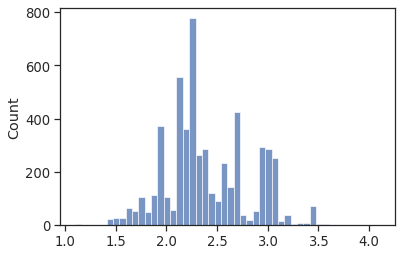

In [4]:
def estimate_average_length(Mn, name1, name2, f1, f2, d1=None, d2=None):
    """
    Mn = number average mass of polymer
    f* = volume fractions
    d* = densities
    """

    # MW of repeat unit of each block
    mw1 = df_names2chemprop.loc[name1, 'mw_repeat_unit']
    mw2 = df_names2chemprop.loc[name2, 'mw_repeat_unit']

    # get densities
    if d1 is None or np.isnan(d1):
        #d1 = df_names_dict.loc[name1, 'Density (g/mL) if not reported in article']
        d1 = df_names_dict.loc[name1, 'Density (g/mL) from Arora et al in SI']
    if d2 is None or np.isnan(d2):
        #d2 = df_names_dict.loc[name2, 'Density (g/mL) if not reported in article']
        d2 = df_names_dict.loc[name2, 'Density (g/mL) from Arora et al in SI']

    if np.isnan(d1) or np.isnan(d2):
        print(name1, name2, d1, d2)

    # get mole fractions
    relative_Mn1 = f1 * d1
    relative_Mn2 = f2 * d2
    relative_N1 = relative_Mn1 / mw1
    relative_N2 = relative_Mn2 / mw2
    N1 = relative_N1 / (relative_N1 + relative_N2)
    N2 = relative_N2 / (relative_N1 + relative_N2)

    # degree of polym
    N = Mn / ((mw1 * N1) + (mw2 * N2))
    
    return N1, N2, N



all_N = []
all_N1 = []
all_N2 = []

for index, row in df.iterrows():
    N1, N2, N = estimate_average_length(Mn=row['Mn'], name1=row['name1'], name2=row['name2'], f1=row['f1'], f2=row['f2'], d1=row['rho1'], d2=row['rho2'])
    all_N.append(N)
    all_N1.append(N1)
    all_N2.append(N2)

sns.histplot(np.log10(all_N))
print(min(all_N), max(all_N))

df.loc[:, 'N1'] = all_N1
df.loc[:, 'N2'] = all_N2
df.loc[:, 'N'] = all_N

In [5]:
# -------------
# Filter phases
# -------------
phases_to_keep = ['lamellar', 'cylinder', 'sphere', 'gyroid', 'disordered']
mask1 = [s in phases_to_keep for s in df.loc[:, 'phase1']]
mask2 = []
for s in df.loc[:, 'phase2']:
    if isinstance(s, str):
        if s in phases_to_keep:
            mask2.append(True)
        else:
            mask2.append(False)
    else:
        mask2.append(True)
mask = np.logical_and(mask1, mask2)

df = df.loc[mask, :]
df = df.reset_index(drop=True)
df

,name1,name2,BigSMILES,phase1,phase2,T,f1,f2,rho1,rho2,Mn,DOI,N1,N2,N
0,PS,PDMS,{[][$]CC(c1ccccc1)[$][$]}{[>][<][Si](C)(C)O[>][]},sphere,NaN,25.0,0.08,0.92,NaN,NaN,60803.57143,https://doi.org/10.1016/0032-3861(95)99001-B,0.055106,0.944894,802.074138
1,PS,PDMS,{[][$]CC(c1ccccc1)[$][$]}{[>][<][Si](C)(C)O[>][]},cylinder,NaN,25.0,0.16,0.84,NaN,NaN,66576.57658,https://doi.org/10.1016/0032-3861(95)99001-B,0.113278,0.886722,858.468001
2,PS,PDMS,{[][$]CC(c1ccccc1)[$][$]}{[>][<][Si](C)(C)O[>][]},lamellar,NaN,25.0,0.35,0.65,NaN,NaN,43669.72477,https://doi.org/10.1016/0032-3861(95)99001-B,0.265320,0.734680,531.822911
3,PS,PDMS,{[][$]CC(c1ccccc1)[$][$]}{[>][<][Si](C)(C)O[>][]},cylinder,NaN,25.0,0.56,0.44,NaN,NaN,42735.84906,https://doi.org/10.1016/0032-3861(95)99001-B,0.460509,0.539491,485.811566
4,PS,PDMS,{[][$]CC(c1ccccc1)[$][$]}{[>][<][Si](C)(C)O[>][]},cylinder,NaN,25.0,0.66,0.34,NaN,NaN,39056.60377,https://doi.org/10.1016/0032-3861(95)99001-B,0.565579,0.434421,428.630355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4775,PEO,PEE,"{[][<]CCO[>][<]}{[$][$]CCCC[$],[$]CC(CC)[$][]}",gyroid,NaN,223.0,0.70,0.30,NaN,NaN,8400.00000,10.1126/science.271.5251.976,0.778738,0.221262,179.802306
4776,PEO,PEE,"{[][<]CCO[>][<]}{[$][$]CCCC[$],[$]CC(CC)[$][]}",gyroid,NaN,224.0,0.70,0.30,NaN,NaN,8400.00000,10.1126/science.271.5251.976,0.778738,0.221262,179.802306
4777,PEO,PEE,"{[][<]CCO[>][<]}{[$][$]CCCC[$],[$]CC(CC)[$][]}",gyroid,NaN,225.0,0.70,0.30,NaN,NaN,8400.00000,10.1126/science.271.5251.976,0.778738,0.221262,179.802306
4778,PEO,PEE,"{[][<]CCO[>][<]}{[$][$]CCCC[$],[$]CC(CC)[$][]}",gyroid,NaN,226.0,0.70,0.30,NaN,NaN,8400.00000,10.1126/science.271.5251.976,0.778738,0.221262,179.802306


<AxesSubplot:xlabel='phase1', ylabel='Count'>

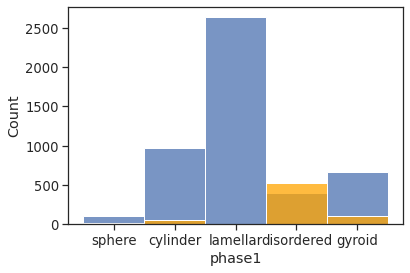

In [6]:
sns.histplot(df.loc[:, 'phase1'])
sns.histplot(df.loc[:, 'phase2'], color='orange')

In [6]:
# ----------------------
# One-hot encode phases
# ----------------------
one_hot_phases = {p:[] for p in phases_to_keep}
for p1,p2 in zip(df.loc[:, 'phase1'], df.loc[:, 'phase2']):
    for p in one_hot_phases.keys():
        if p in (p1, p2):
            one_hot_phases[p].append(1)
        else:
            one_hot_phases[p].append(0)

# add one hot encoding in df
for k,v in one_hot_phases.items():
    df.loc[:, k] = v

df

,name1,name2,BigSMILES,phase1,phase2,T,f1,f2,rho1,rho2,Mn,DOI,N1,N2,N,lamellar,cylinder,sphere,gyroid,disordered
0,PS,PDMS,{[][$]CC(c1ccccc1)[$][$]}{[>][<][Si](C)(C)O[>][]},sphere,NaN,25.0,0.08,0.92,NaN,NaN,60803.57143,https://doi.org/10.1016/0032-3861(95)99001-B,0.055106,0.944894,802.074138,0,0,1,0,0
1,PS,PDMS,{[][$]CC(c1ccccc1)[$][$]}{[>][<][Si](C)(C)O[>][]},cylinder,NaN,25.0,0.16,0.84,NaN,NaN,66576.57658,https://doi.org/10.1016/0032-3861(95)99001-B,0.113278,0.886722,858.468001,0,1,0,0,0
2,PS,PDMS,{[][$]CC(c1ccccc1)[$][$]}{[>][<][Si](C)(C)O[>][]},lamellar,NaN,25.0,0.35,0.65,NaN,NaN,43669.72477,https://doi.org/10.1016/0032-3861(95)99001-B,0.265320,0.734680,531.822911,1,0,0,0,0
3,PS,PDMS,{[][$]CC(c1ccccc1)[$][$]}{[>][<][Si](C)(C)O[>][]},cylinder,NaN,25.0,0.56,0.44,NaN,NaN,42735.84906,https://doi.org/10.1016/0032-3861(95)99001-B,0.460509,0.539491,485.811566,0,1,0,0,0
4,PS,PDMS,{[][$]CC(c1ccccc1)[$][$]}{[>][<][Si](C)(C)O[>][]},cylinder,NaN,25.0,0.66,0.34,NaN,NaN,39056.60377,https://doi.org/10.1016/0032-3861(95)99001-B,0.565579,0.434421,428.630355,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4775,PEO,PEE,"{[][<]CCO[>][<]}{[$][$]CCCC[$],[$]CC(CC)[$][]}",gyroid,NaN,223.0,0.70,0.30,NaN,NaN,8400.00000,10.1126/science.271.5251.976,0.778738,0.221262,179.802306,0,0,0,1,0
4776,PEO,PEE,"{[][<]CCO[>][<]}{[$][$]CCCC[$],[$]CC(CC)[$][]}",gyroid,NaN,224.0,0.70,0.30,NaN,NaN,8400.00000,10.1126/science.271.5251.976,0.778738,0.221262,179.802306,0,0,0,1,0
4777,PEO,PEE,"{[][<]CCO[>][<]}{[$][$]CCCC[$],[$]CC(CC)[$][]}",gyroid,NaN,225.0,0.70,0.30,NaN,NaN,8400.00000,10.1126/science.271.5251.976,0.778738,0.221262,179.802306,0,0,0,1,0
4778,PEO,PEE,"{[][<]CCO[>][<]}{[$][$]CCCC[$],[$]CC(CC)[$][]}",gyroid,NaN,226.0,0.70,0.30,NaN,NaN,8400.00000,10.1126/science.271.5251.976,0.778738,0.221262,179.802306,0,0,0,1,0


In [8]:
# ======================
# Create Chemprop Inputs
# ======================
master_chemprop_inputs = []
poly_chemprop_inputs = []

use_stoich = False
use_chain_arch = False
use_Xn = True


def get_max_Rnum(s):
    star_indices = [i for i, ltr in enumerate(s) if ltr == '*']
    num_indices = [i+2 for i in star_indices]
    star_nums = [int(s[i]) for i in num_indices]
    return max(star_nums)


def update_nums(start_num, smi, rule):
    
    # get num mapping
    star_indices = [i for i, ltr in enumerate(smi) if ltr == '*']
    num_indices = [i+2 for i in star_indices]
    nums = [int(smi[i]) for i in num_indices]

    num_map = {}
    for i, n in enumerate(nums):
        num_map[n] = start_num + i

    # process smiles
    smi_list = [c for c in smi]
    for i in num_indices:
        smi_list[i] = str(num_map[int(smi[i])])
    new_smi = "".join(smi_list)

    # process rule
    new_rule = ''
    for r in rule.split('<')[1:]:
        new_rule += '<'
        r_list = r.split(':')
        n1 = r_list[0].split('-')[0]
        n2 = r_list[0].split('-')[1]
            
        new_rule += str(num_map[int(n1)])
        new_rule += '-'
        new_rule += str(num_map[int(n2)])
        new_rule += ':'
        new_rule += ":".join(r_list[1:])
        
    return new_smi, new_rule


for index, row in df.iterrows():
    name1 = row['name1']
    name2 = row['name2']

    # ---------------
    # Master Chemprop
    # ---------------
    
    # Smiles 1
    smi1 = df_names2chemprop.loc[name1, 'smiles']

    # Smiles 2
    smi2 = df_names2chemprop.loc[name2, 'smiles']

    master_chemprop_input = f"{smi1}.{smi2}"
    master_chemprop_inputs.append(master_chemprop_input)

    # ---------------
    # Poly Chemprop
    # ---------------

    # String 1
    smi1 = df_names2chemprop.loc[name1, 'poly_chemprop_smiles']
    rule1 = df_names2chemprop.loc[name1, 'poly_chemprop_extra_bonds']

    # String 2
    smi2 = df_names2chemprop.loc[name2, 'poly_chemprop_smiles']
    rule2 = df_names2chemprop.loc[name2, 'poly_chemprop_extra_bonds']

    # update smi2 and rule2
    max_num1 = get_max_Rnum(smi1)
    smi2, rule2 = update_nums(max_num1+1, smi2, rule2)

    # get block fractions
    if use_stoich is True:
        N1 = row['N1']
        N2 = row['N2']
    else:
        N1 = 1
        N2 = 1

    # whether to remove rules
    if use_chain_arch is False:
        rule1 = '<'
        rule2 = ''

    # degree of polym
    if use_Xn is True:
        N = row['N']
    else:
        N = 1.

    # get number of monomers in each block
    num_monos1 = len(smi1.split('.'))
    num_monos2 = len(smi2.split('.'))

    poly_chemprop_input = f"{smi1}.{smi2}|" + f"{N1}|"*num_monos1 + f"{N2}|"*num_monos2 + f"{rule1}{rule2}~{N}"
    poly_chemprop_inputs.append(poly_chemprop_input)


df.loc[:, 'master_chemprop_input'] = master_chemprop_inputs
df.loc[:, 'poly_chemprop_input'] = poly_chemprop_inputs

In [10]:
df_out = df.loc[:, ['master_chemprop_input']+phases_to_keep]
df_out.to_csv('dataset-master_chemprop.csv', index=False)

In [31]:
df_out = df.loc[:, ['poly_chemprop_input']+phases_to_keep]

#df_out.to_csv('dataset-polymer_chemprop-stoich-chain-Xn.csv', index=False)
#df_out.to_csv('dataset-polymer_chemprop-stoich-chain.csv', index=False)
#df_out.to_csv('dataset-polymer_chemprop-stoich-Xn.csv', index=False)
#df_out.to_csv('dataset-polymer_chemprop-chain-Xn.csv', index=False)
#df_out.to_csv('dataset-polymer_chemprop-stoich.csv', index=False)
#df_out.to_csv('dataset-polymer_chemprop-chain.csv', index=False)
df_out.to_csv('dataset-polymer_chemprop-Xn.csv', index=False)

In [9]:
frac_positives = np.sum(df.loc[:, phases_to_keep].to_numpy(), axis=0) / len(df)
macro_prc_baseline = np.mean(frac_positives)
macro_prc_baseline

0.22903765690376568

# Fingerprint inputs for RF models
------------------

(i) create 32 random sequences for each polymer

(ii) take their count FP, average, and normalize by length (i.e. divide by 32)

(iii) for each co-polymer in the dataset: 

   - take weighted average of the 2 fingerprints according to N1 and N2
   - multiply resulting FP by 1 + log(Xn), i.e. deg of polym

In [10]:
# These are smiles where R groups have been replaced by dummy atoms so 
# we can use reaction smarts to generate oligomers. Two simple rules
# are sufficient for this dataset:
# (i) I reacts with any I
# (ii) F reacts Br
# F, Br, I are not present in these polymers
poly_smiles = df_names2chemprop.loc[:, 'smiles_with_dummy_halogens'].to_numpy()
poly_names = df_names2chemprop.index.to_numpy()



def rm_duplicate_mols(mols):
    smiles = list(set([Chem.MolToSmiles(m, canonical=True) for m in mols]))
    mols = [Chem.MolFromSmiles(s) for s in smiles]
    return mols


def react(m1, m2):

    atoms = [a.GetSymbol() for a in m1.GetAtoms()]
    if 'I' in atoms:
        smarts = "[*:1]I.[*:2]I>>[*:1]-[*:2]"
    elif 'F' in atoms or 'Br' in atoms:
        smarts = "[*:1]F.[*:2]Br>>[*:1]-[*:2]"

    rxn = AllChem.ReactionFromSmarts(smarts)
    ps = rxn.RunReactants((m1,m2))
    products = rm_duplicate_mols([m[0] for m in ps])
    
    # return a product at random
    return np.random.choice(products)


def loop(m):
    atoms = [a.GetSymbol() for a in m.GetAtoms()]
    if 'I' in atoms:
        smarts = "([*:1]I.[*:2]I)>>[*:1]-[*:2]"
    elif 'F' in atoms or 'Br' in atoms:
        smarts = "([*:1]F.[*:2]Br)>>[*:1]-[*:2]"

    rxn = AllChem.ReactionFromSmarts(smarts)
    ps = rxn.RunReactants((m,))
    products = rm_duplicate_mols([m[0] for m in ps])

    assert len(products) == 1
    
    # return a product at random
    return products[0]


def rm_dummy_halogens(m):
    # rm all Br, F, I
    for halogen in ['F', 'Br', 'I']:
        while m.HasSubstructMatch(Chem.MolFromSmarts(f'{halogen}')):
            smarts = f"[*:1]{halogen}>>[*:1]"
            rxn = AllChem.ReactionFromSmarts(smarts)
            ps = rxn.RunReactants((m,))
            products = rm_duplicate_mols([m[0] for m in ps])
            m = products[0]
    return m


def get_fps(polys, nBits=2048, radius=2, norm_const=1, count=True):
    if count is True:
        # Count fingerprints
        poly_fp_objs = np.array([AllChem.GetHashedMorganFingerprint(m, radius=radius, nBits=nBits) for m in polys])
        poly_fp_arrs = np.array([np.zeros((nBits,), dtype=np.float64)] * len(poly_fp_objs))
        _ = [DataStructs.ConvertToNumpyArray(fpo, fpa) for fpo, fpa in zip(poly_fp_objs, poly_fp_arrs)]
        polys_fps = poly_fp_arrs
        fp = np.mean(polys_fps, axis=0) / norm_const
    else:
        # Binary fingerprints
        polys_fps = np.array([AllChem.GetMorganFingerprintAsBitVect(m, radius=radius, nBits=nBits) for m in polys]).astype(np.float64)
        fp = np.mean(polys_fps, axis=0)
    return fp

In [11]:
oligo_length = 12
n_sequences = 32
use_count_fps = True

name2fps = {}

# iterate over all polymer
for name, poly_smi in zip(poly_names, poly_smiles):

    mono_smiles = poly_smi.split('.')
    
    # create N random oligomers
    oligomers = []
    for i_seq in range(n_sequences):

        # pick one mono smi at random
        oligomer = Chem.MolFromSmiles(np.random.choice(mono_smiles))

        for i in range(oligo_length - 1):
            # select next monomer
            next_monomer = Chem.MolFromSmiles(np.random.choice(mono_smiles))
            oligomer = react(oligomer, next_monomer)

        # create cycle
        oligomer = loop(oligomer)
        oligomers.append(oligomer)

    fp = get_fps(oligomers, nBits=2048, radius=2, norm_const=n_sequences, count=use_count_fps)
    name2fps[name] = fp

In [42]:
fps_diblock = []

for index, row in df.iterrows():
    name1 = row['name1'].strip()
    name2 = row['name2'].strip()
    N1 = row['N1']
    N2 = row['N2']
    N = row['N']

    # get block fps
    fp1 = name2fps[name1] 
    fp2 = name2fps[name2]

    # weight fingerprints by block fractions, and multiply by polymer size

    fp_diblock = (fp1 * N1 + fp2 * N2) * (1. + np.log10(N))
    #fp_diblock = fp1 * N1 + fp2 * N2 
    #fp_diblock = (fp1 + fp2) * (1. + np.log10(N))
    #fp_diblock = fp1 + fp2

    fps_diblock.append(fp_diblock)

In [43]:
X = pd.DataFrame(fps_diblock, columns=[f'bit-{x}' for x in range(len(fps_diblock[0]))])
Y = df.loc[:, phases_to_keep]
data = {'X':X, 'Y':Y}
with open('dataset-fps_counts-chain_stoich_Xn.pkl', 'wb') as f:
    pickle.dump(data, f)

In [44]:
# ==================
# Simple Monomer FPS
# ==================

use_count_fps = True
radius = 2
nBits = 2048

mols = [Chem.MolFromSmiles(smi) for smi in df.loc[:, 'master_chemprop_input']]

if use_count_fps is True:
    # Count fingerprints
    poly_fp_objs = np.array([AllChem.GetHashedMorganFingerprint(m, radius=radius, nBits=nBits) for m in mols])
    poly_fp_arrs = np.array([np.zeros((nBits,), dtype=np.float64)] * len(poly_fp_objs))
    _ = [DataStructs.ConvertToNumpyArray(fpo, fpa) for fpo, fpa in zip(poly_fp_objs, poly_fp_arrs)]
    polys_fps = poly_fp_arrs
else:
    # Binary fingerprints
    polys_fps = np.array([AllChem.GetMorganFingerprintAsBitVect(m, radius=radius, nBits=nBits) for m in mols]).astype(np.float64)


X = pd.DataFrame(polys_fps, columns=[f'bit-{x}' for x in range(len(polys_fps[0]))])
Y = df.loc[:, phases_to_keep]
data = {'X':X, 'Y':Y}

fname = 'dataset-fps_counts.pkl' if use_count_fps else 'dataset-fps_binary.pkl'
with open(fname, 'wb') as f:
    pickle.dump(data, f)

In [47]:
# ================================================
# Simple Monomer FPS with Stoichiometry/Size Info
# ================================================

use_count_fps = True
radius = 2
nBits = 2048

with_stoich = False
with_Xn = True

# Smiles of block 1 and 2
smiles1 = [df_names2chemprop.loc[name, 'smiles'] for name in df.loc[:, 'name1']]
smiles2 = [df_names2chemprop.loc[name, 'smiles'] for name in df.loc[:, 'name2']]
# Mole of block 1 and 2
mols1 = [Chem.MolFromSmiles(smi) for smi in smiles1]
mols2 = [Chem.MolFromSmiles(smi) for smi in smiles2]
# Mole fractions of block 1 and 2
N1 = df.loc[:, 'N1'].to_numpy()
N2 = df.loc[:, 'N2'].to_numpy()

N = df.loc[:, 'N'].to_numpy()

if use_count_fps is True:
    # Count fingerprints of block 1
    poly_fp_objs1 = np.array([AllChem.GetHashedMorganFingerprint(m, radius=radius, nBits=nBits) for m in mols1])
    poly_fp_arrs1 = np.array([np.zeros((nBits,), dtype=np.float64)] * len(poly_fp_objs1))
    _ = [DataStructs.ConvertToNumpyArray(fpo, fpa) for fpo, fpa in zip(poly_fp_objs1, poly_fp_arrs1)]

    # Count fingerprints of block 2
    poly_fp_objs2 = np.array([AllChem.GetHashedMorganFingerprint(m, radius=radius, nBits=nBits) for m in mols2])
    poly_fp_arrs2 = np.array([np.zeros((nBits,), dtype=np.float64)] * len(poly_fp_objs2))
    _ = [DataStructs.ConvertToNumpyArray(fpo, fpa) for fpo, fpa in zip(poly_fp_objs2, poly_fp_arrs2)]
    
    if with_stoich is True:
        polys_fps = poly_fp_arrs1 * N1.reshape(-1,1) + poly_fp_arrs2 * N2.reshape(-1,1)
    else:
        polys_fps = poly_fp_arrs1 + poly_fp_arrs2

    if with_Xn is True:
        polys_fps = polys_fps * (1. + np.log10(N.reshape(-1,1)))
else:
    # Binary fingerprints
    polys_fps1 = np.array([AllChem.GetMorganFingerprintAsBitVect(m, radius=radius, nBits=nBits) for m in mols1]).astype(np.float64)
    polys_fps2 = np.array([AllChem.GetMorganFingerprintAsBitVect(m, radius=radius, nBits=nBits) for m in mols2]).astype(np.float64)
    polys_fps = polys_fps1 * N1 + polys_fps2 * N2


X = pd.DataFrame(polys_fps, columns=[f'bit-{x}' for x in range(len(polys_fps[0]))])
Y = df.loc[:, phases_to_keep]
data = {'X':X, 'Y':Y}


# save fps as pkl
fname = 'dataset-'
if use_count_fps is True:
    fname += 'fps_counts'
else:
    fname += 'fps_binary'

if with_stoich is True:
    fname += '-stoich'
if with_Xn is True:
    fname += '-Xn'

fname += '.pkl'
with open(fname, 'wb') as f:
    pickle.dump(data, f)

In [56]:
# =================
# No Chemistry Data
# =================

X = df.loc[:, ['N1', 'N']]
Y = df.loc[:, phases_to_keep]
data = {'X':X, 'Y':Y}

with open('dataset-N1_Xn.pkl', 'wb') as f:
    pickle.dump(data, f)

## Dataset splits

In [16]:
n_splits = 10
X = df.loc[:, 'master_chemprop_input']
y = df.loc[:, 'phase1']


cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

folds = []
for train_idx, test_idx in cv.split(X, y):
    folds.append([train_idx, test_idx])

In [18]:
# add validation split
kfold_indices = []
for i, fold in enumerate(folds):
    train, test = fold
    # use test indices from previous fold as validation
    val = folds[i-1][1]
    # rm val indices from train indices
    train = [x for x in train if x not in val]
    
    kfold = {'train_idx':train, 'val_idx':val, 'test_idx':test}
    kfold_indices.append(kfold)

In [317]:
# save kfold indices to pickle file
with open(f'cv10-stratified.pkl', 'wb') as f:
    pickle.dump(kfold_indices, f)

# Some analysis of phase dependence on volume fractions and mass
-----

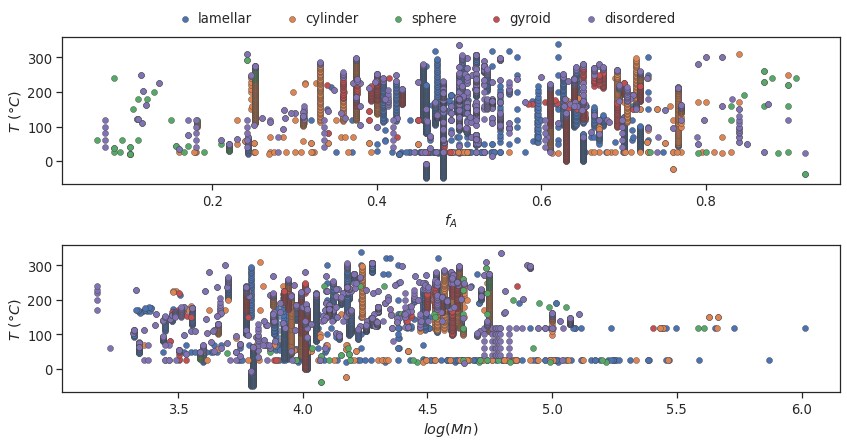

In [8]:
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(12,6))

colors = sns.color_palette('deep', 5)

for i, phase in enumerate(['lamellar', 'cylinder', 'sphere', 'gyroid', 'disordered']):
    mask = df.loc[:, phase] == 1

    axes[0].scatter(df.loc[mask, 'f1'], df.loc[mask, 'T'], alpha=1, color=colors[i], label=phase, edgecolor='#444444', linewidths=0.4)
    axes[0].set_xlabel('$f_A$')
    axes[0].set_ylabel('$T\ (\degree C$)')
    
    axes[1].scatter(np.log10(df.loc[mask, 'Mn']), df.loc[mask, 'T'], alpha=1, color=colors[i], edgecolor='#444444', linewidths=0.4)
    axes[1].set_xlabel('$log(Mn)$')
    axes[1].set_ylabel('$T\ (\degree C$)')
    
fig.legend(ncol=5, frameon=False, loc='upper center', handletextpad=0., columnspacing=2, bbox_to_anchor=(0.5, 1.05))

plt.tight_layout()

fig.savefig(f'fA_Mn_T_vs_phases.png', dpi=1200, bbox_inches='tight')

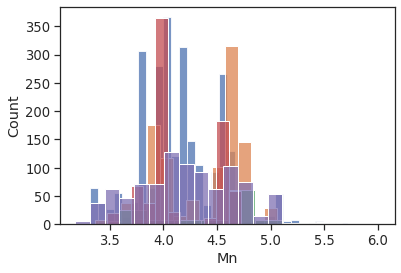

In [20]:
for i, phase in enumerate(['lamellar', 'cylinder', 'sphere', 'gyroid', 'disordered']):
    mask = df.loc[:, phase] == 1
    sns.histplot(np.log10(df.loc[mask, 'Mn']), color=colors[i], label=phase)